In [1]:
#@markdown #USCMS Diveristy Data: Gender Count per Activity
#@markdown Count gender per professional activity for various years

#@markdown ### Import `python` libraries

import os, json
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import ipywidgets as widgets

from google.colab import drive
drive.mount( '/content/drive' )

%cd /content/drive/My Drive/Physics Research/CMS/Analysis/USCMS-diversity-analysis-main/

Mounted at /content/drive
/content/drive/My Drive/Physics Research/CMS/Analysis/USCMS-diversity-analysis-main


In [2]:
#@markdown ### Select and Load in the Relevant `json` Files
#@markdown Choose the years to consolidate
people_stats = [ option for option in os.listdir( "./Data/" ) if "people_stats" in option ]
work = [ option for option in os.listdir( "./Data/" ) if "work" in option ]
people_stats_years = [ name.split(".")[0].split("_")[2][:4] for name in people_stats ]
work_years = [ name.split(".")[0].split("_")[1][:4] for name in work ]
valid_years = list( set(people_stats_years).intersection(work_years) )
yearlist = widgets.SelectMultiple( options = sorted(valid_years) )
yearlist

SelectMultiple(options=('2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'…

In [40]:
#@markdown Load in the `json` files
region_key = {
    "FRANCE": ["FRANCE"],
    "GERMANY": ["GERMANY"],
    "ITALY": ["ITALY"],
    "SWITZERLAND": ["SWITZERLAND"],
    "UNITED KINGDOM": ["UNITED KINGDOM"],
    "USCMS": ["USA"],
    "CERN":["CERN","CERN-BASED"],
    "RDMS":["RUSSIA","ARMENIA","BELARUS","GEORGIA","UZBEKISTAN"],
    "CERN OTHER":["AUSTRIA","BELGIUM","BULGARIA","FINLAND","GREECE","HUNGARY","POLAND","PORTUGAL","SERBIA","SPAIN"],
    "OTHER A":["CHINA","INDIA","IRAN","KOREA","MALAYSIA","NEW ZEALAND","PAKISTAN","SRI LANKA","TAIWAN","THAILAND"],
    "OTHER B":["BAHRAIN","BRAZIL","COLOMBIA","CROATIA","CYPRUS","ECUADOR","EGYPT","ESTONIA","IRELAND","KUWAIT","LEBANON","LATVIA","LITHUANIA","MEXICO","MONTENEGRO","OMAN","QATAR","SAUDI ARABIA","TURKEY","UKRAINE"],
    "OTHER C":[],
    "INDIA":["INDIA"]
}

json_files = {
    "people_new": json.load( open( "Data/people_new.json" ) ),
    "institutes_new": json.load( open( "Data/institutes_new.json" ) ),
    "people_stats": { year: json.load( open( "Data/people_stats_{}1231.json".format( year ) ) ) for year in yearlist.value }
}

institute_list = np.array( [ list( institute.values() ) for institute in json_files[ "institutes_new" ] ] )

id_info = {}
for person in json_files[ "people_new" ]:
  id_info[ str( person[ "cmsId" ] ) ] = { 
    "BIRTHYEAR": person[ "birthYear" ],
    "GENDER": person[ "gender" ]   
  }

data = {
    year: {} for year in yearlist.value
}

for year in yearlist.value:
  for person in json_files[ "people_stats" ][ year ]:
    data[ year ][ str( person[ "cms_id" ] ) ] = {
        "ACTIVITY": person[ "activity_cms" ],
        "INSTITUTE": person[ "inst_code" ],
        "AUTHOR": person[ "is_author" ],
        "STATUS": person[ "status_cms" ],
        "GENDER": id_info[ str( person[ "cms_id" ] ) ][ "GENDER" ],
        "BIRTHYEAR": id_info[ str( person[ "cms_id" ] ) ][ "GENDER" ]
    }
    if person[ "activity_cms" ] != None:
      if ( "Engineer" in person[ "activity_cms" ] and "Software" not in person[ "activity_cms" ] ) or person[ "activity_cms" ] == "Technician":
        data[ year ][ str( person[ "cms_id" ] ) ][ "ACTIVITY" ] = "Engineer/Technician"

  print( "Adding regions for {}".format( year ) )
  for cms_id in data[ year ]:
    this_index = np.argwhere( institute_list[:,0] == data[ year ][ cms_id ][ "INSTITUTE" ] )[0,0]
    this_country = institute_list[ this_index, 1 ].upper()
    if data[ year ][ cms_id ][ "INSTITUTE" ].upper() in [ "CERN", "CERN-BASED" ]:
      this_country = "CERN"
    has_region = False
    for region in region_key.keys():
      if this_country in region_key[ region ]:
        data[ year ][ cms_id ][ "REGION" ] = region
        has_region = True
        continue
    if has_region == False:
      data[ year ][ cms_id ][ "REGION" ] = "OTHER C"
      if this_country not in region_key["OTHER C"]: 
        print( ">> Adding {} to Other C".format( this_country ) )
        region_key["OTHER C"].append( this_country )

Adding regions for 2015
>> Adding ZZ to Other C
>> Adding SINGAPORE to Other C
>> Adding SLOVAK REPUBLIC to Other C
>> Adding CZECH REPUBLIC to Other C
>> Adding NETHERLANDS to Other C
>> Adding CANADA to Other C
>> Adding PHILIPPINES to Other C
>> Adding ROMANIA to Other C
>> Adding JAPAN to Other C
>> Adding NORWAY to Other C
>> Adding TUNISIA to Other C
Adding regions for 2016
Adding regions for 2017
Adding regions for 2018
Adding regions for 2019
Adding regions for 2020
>> Adding JORDAN to Other C
Adding regions for 2021


In [4]:
#@markdown Choose a CMS Status to report

status_options = []

for year in yearlist.value:
  for person in json_files[ "people_stats" ][ year ]:
    if person[ "status_cms" ] not in status_options:
      if person[ "status_cms" ] != None and person[ "status_cms" ] != "":
        status_options.append( person[ "status_cms" ] )

status = widgets.SelectMultiple( options = sorted( status_options ), value = [ "CMS", "CMSAFFILIATE", "CMSASSOC", "CMSEMERITUS", "CMSEXTENDED" ] )
status

SelectMultiple(index=(1, 3, 4, 5, 6), options=('CERN', 'CMS', 'CMS iCMSfor9981_01/01/2019-Author:True', 'CMSAF…

In [5]:
#@markdown Select authorship status to report:
author_legend = {
    "AUTHORS": [ True ],
    "ALL MEMBERS": [ True, False, None ],
    "NON-AUTHORS": [ False ],
    "REPORTED MEMBERS": [ True, False ],
    "UNREPORTED MEMBERS": [ None ],
    "AUTHORS and UNREPORTED": [ True, None ],
    "NON-AUTHORS and UNREPORTED": [ False, None ]
}
author = widgets.Select( options = author_legend.keys(), value = "AUTHORS" )
author

Select(options=('AUTHORS', 'ALL MEMBERS', 'NON-AUTHORS', 'REPORTED MEMBERS', 'UNREPORTED MEMBERS', 'AUTHORS an…

In [6]:
#@markdown Select professional activities to report
activity_options = []
for year in yearlist.value:
  for cmsID in data[ year ]:
    if data[ year ][ cmsID ][ "ACTIVITY" ] not in activity_options and data[ year ][ cmsID ][ "ACTIVITY" ] != None : 
      activity_options.append( data[ year ][ cmsID ][ "ACTIVITY" ] )

activities = widgets.SelectMultiple( options = sorted( activity_options ) )
activities

SelectMultiple(options=('Administrative', 'Doctoral Student', 'Engineer Software', 'Engineer/Technician', 'Non…

In [7]:
#@markdown Select region to report
regions = widgets.Select( options = region_key.keys(), value = "USCMS" )
regions 

Select(index=5, options=('FRANCE', 'GERMANY', 'ITALY', 'SWITZERLAND', 'UNITED KINGDOM', 'USCMS', 'CERN', 'RDMS…

In [41]:
#@markdown Count the genders for each activity
count_activity = {
    year: {
        category: {
            activity: 0 for activity in activities.value
        } for category in [ "MALE", "FEMALE", "TOTAL", "FRACTION_F", "FRACTION_M" ]
    } for year in yearlist.value
}

max_count = 0

for year in yearlist.value:
  print( "Counting for {}...".format( year ) ) 
  for cmsID in data[ year ]:
    if data[ year ][ cmsID ][ "REGION" ] != regions.value: continue
    if data[ year ][ cmsID ][ "AUTHOR" ] in author_legend[ author.value ] and data[ year ][ cmsID ][ "STATUS" ] in status.value:
      for activity in activities.value:
        if data[ year ][ cmsID ][ "ACTIVITY" ] == activity:
          if data[ year ][ cmsID ][ "GENDER" ] == "M": count_activity[ year ][ "MALE" ][ activity ] += 1
          elif data[ year ][ cmsID ][ "GENDER" ] == "F": count_activity[ year ][ "FEMALE" ][ activity ] += 1
          count_activity[ year ][ "TOTAL" ][ activity ] += 1
  for activity in activities.value:
    if count_activity[ year ][ "TOTAL" ][ activity ] > 0:
      count_activity[ year ][ "FRACTION_F" ][ activity ] = float( count_activity[ year ][ "FEMALE" ][ activity ] ) / float( count_activity[ year ][ "TOTAL" ][ activity ] )
      count_activity[ year ][ "FRACTION_M" ][ activity ] = float( count_activity[ year ][ "MALE" ][ activity ] ) / float( count_activity[ year ][ "TOTAL" ][ activity ] )
    else:
      print( ">> {} has no entries".format( activity ) ) 
    max_count = max( max_count, count_activity[ year ][ "TOTAL" ][ activity ] )

Counting for 2015...
>> Administrative has no entries
>> Non-Doctoral Student has no entries
>> Other has no entries
>> Theoretical Physicist has no entries
Counting for 2016...
>> Administrative has no entries
>> Non-Doctoral Student has no entries
>> Other has no entries
>> Theoretical Physicist has no entries
Counting for 2017...
>> Administrative has no entries
>> Non-Doctoral Student has no entries
>> Other has no entries
>> Theoretical Physicist has no entries
Counting for 2018...
>> Administrative has no entries
>> Non-Doctoral Student has no entries
>> Other has no entries
>> Theoretical Physicist has no entries
Counting for 2019...
>> Administrative has no entries
>> Non-Doctoral Student has no entries
>> Other has no entries
>> Theoretical Physicist has no entries
Counting for 2020...
>> Administrative has no entries
>> Non-Doctoral Student has no entries
>> Other has no entries
>> Theoretical Physicist has no entries
Counting for 2021...
>> Administrative has no entries
>> N

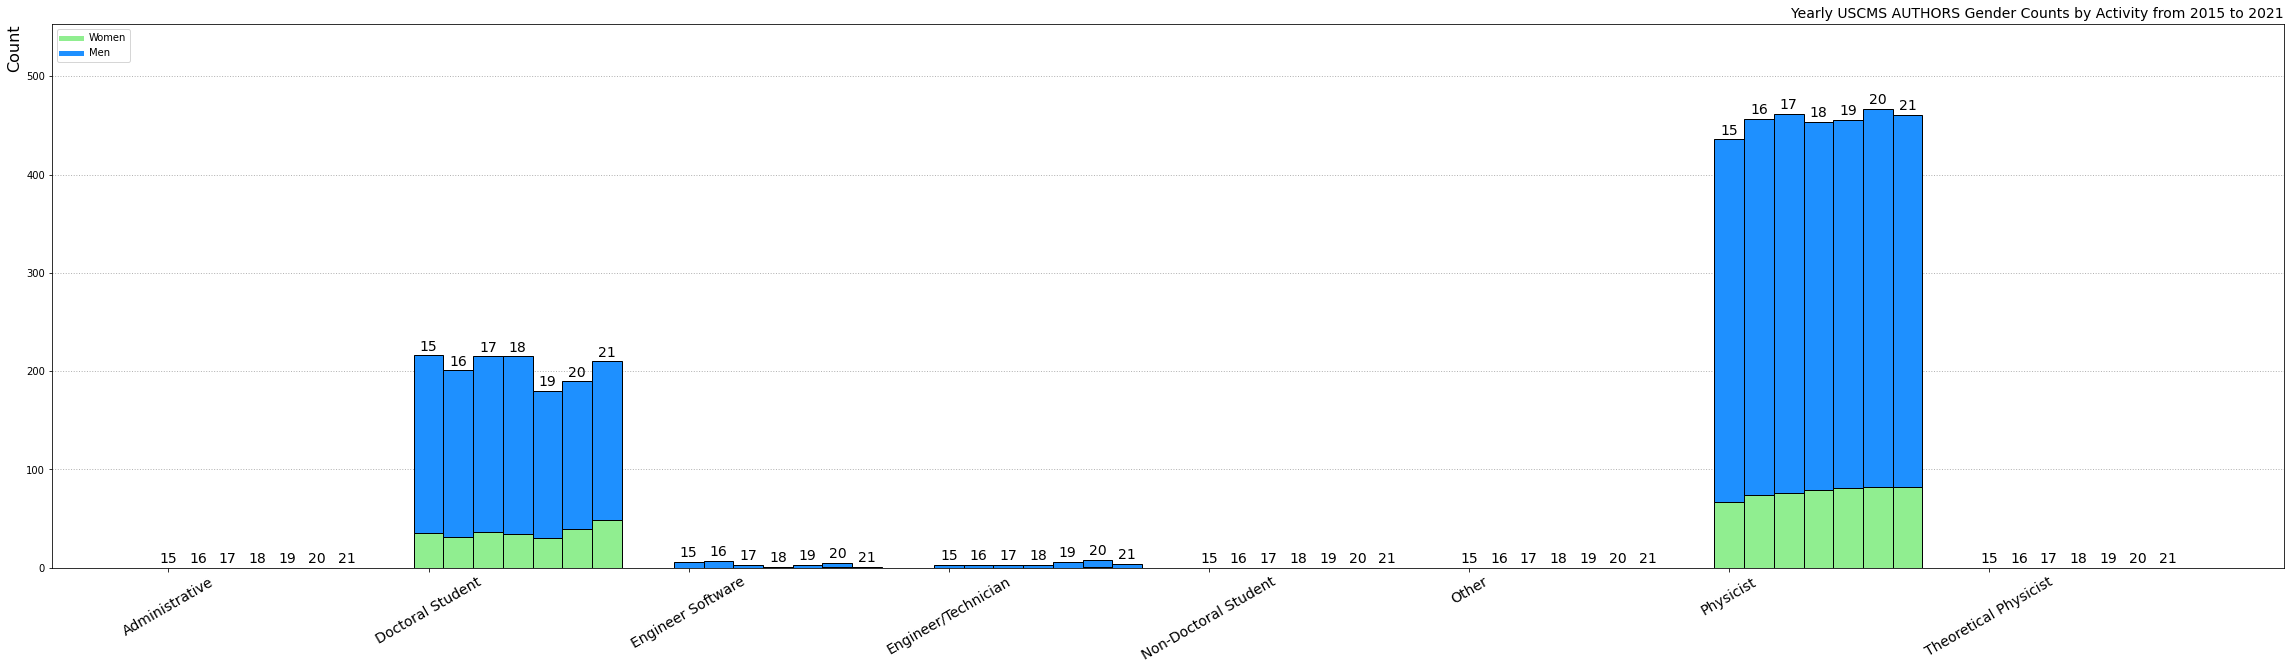

In [42]:
#@markdown ### Plot the Activity Counts by Region per Year

width = 0.8 / len( yearlist.value )
x = np.arange( len( activities.value ) )

plt.figure( figsize = (5 * len(x) , 10) )
ax = plt.subplot(111)

for i, year in enumerate( list( yearlist.value ) ):
    ax.bar( x + width * i, list( count_activity[ year ][ "FEMALE" ].values() )[-len(x):], width,
           color = "lightgreen", edgecolor = "k", zorder=3 )
    ax.bar( x + width * i, list( count_activity[ year ][ "MALE" ].values() )[-len(x):], width,
           bottom = list( count_activity[ year ][ "FEMALE" ].values() )[-len(x):],
           color = "dodgerblue", edgecolor = "k", zorder=3 )
    for xi in x:
      ax.text( 
          xi + width * ( i ), 
          max_count * 0.01 + ( ( np.array( list( count_activity[ year ][ "MALE" ].values() ) ) + np.array( list( count_activity[ year ][ "FEMALE" ].values() ) ) )[xi] ), 
          year[2:], fontsize = 14, ha = "center"  )
      #break
    
ax.set_title( "Yearly {} {} Gender Counts by Activity from {} to {}".format( 
    regions.value, author.value, yearlist.value[0], yearlist.value[-1]
 ), fontsize = 14, x = 1.0, ha = "right" )
ax.set_ylabel( "Count", y = 1.0, ha = "right", fontsize = 16 )
ax.set_ylim( 
    0, 
    1.2*( np.max( ( np.array( list( count_activity[ year ][ "MALE" ].values() ) ) + np.array( list( count_activity[ year ][ "FEMALE" ].values() ) ) ) ) )
)
ax.set_xticks( x )
ax.set_xticklabels( activities.value[-len(x):], fontsize = 14, rotation = 30 )

custom_legend = [
  Line2D( [0], [0], color = "lightgreen", lw = 5 ),
  Line2D( [0], [0], color = "dodgerblue", lw = 5 )
]
ax.legend( custom_legend, [ "Women", "Men" ], loc = 2 )

ax.set_facecolor("white")
ax.grid( b=True, which="major", axis="y", color = [0.7,0.7,0.7], 
        linestyle = ":", linewidth = 1, zorder=0)

if not os.path.exists( os.getcwd() + "/Plots/ ") != True: os.makedirs( os.getcwd() + "/Plots/" )
plt.savefig( "./Plots/Gender by Activity {} {}-{}.png".format( author.value, yearlist.value[0], yearlist.value[-1] ) )
plt.show()

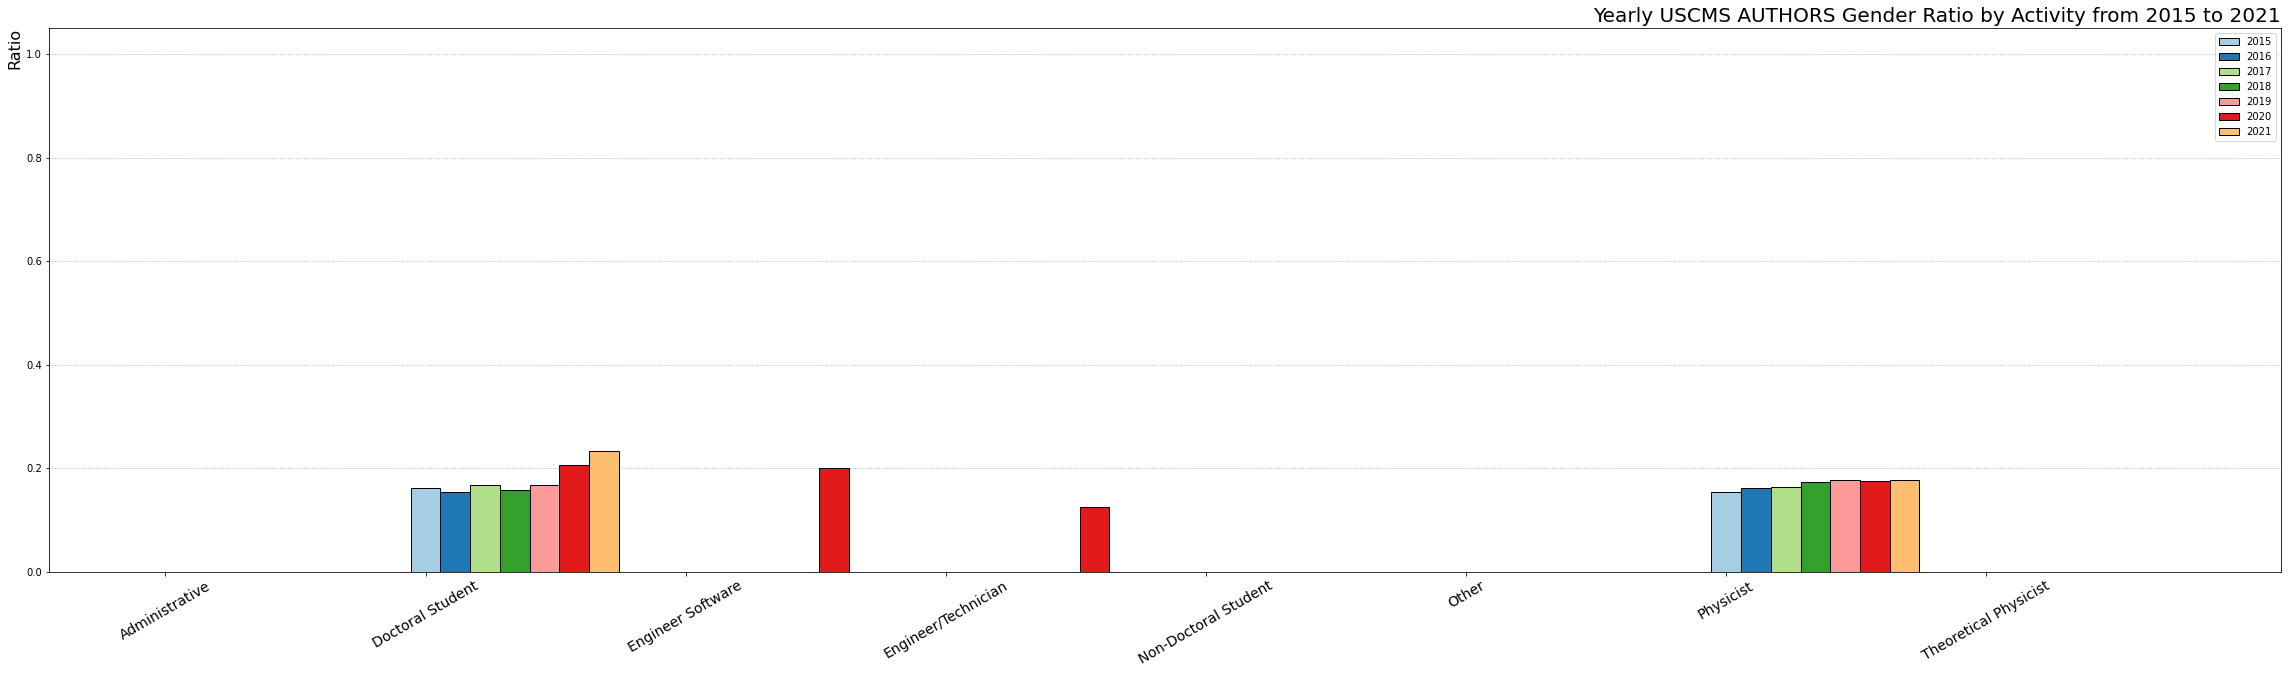

In [43]:
#@markdown ### Plot the Gender Counts by Region per Year

width = 0.8 / len( yearlist.value )
x = np.arange( len( activities.value ) )

plt.figure( figsize = (5 * len(x) , 10) )
ax = plt.subplot(111)

cmap = plt.get_cmap("Paired")

for i, year in enumerate( list( yearlist.value ) ):
    ax.bar( x + width * i, list( count_activity[ year ][ "FRACTION_F" ].values() )[-len(x):], width,
           color = cmap.colors[i], edgecolor = "k", zorder=3, label = year )

    
ax.set_title( "Yearly {} {} Gender Ratio by Activity from {} to {}".format( 
    regions.value, author.value, yearlist.value[0], yearlist.value[-1]
 ), fontsize = 20, x = 1.0, ha = "right" )
ax.set_ylabel( "Ratio", y = 1.0, ha = "right", fontsize = 16 )
ax.set_ylim( 0, 1.05 )
ax.set_xticks( x )
ax.set_xticklabels( activities.value[-len(x):], fontsize = 14, rotation = 30 )

ax.legend( loc = "best" )

ax.set_facecolor("white")
ax.grid( b=True, which="major", axis="y", color = [0.7,0.7,0.7], 
        linestyle = ":", linewidth = 1, zorder=0)

if not os.path.exists( os.getcwd() + "/Plots/ ") != True: os.makedirs( os.getcwd() + "/Plots/" )
plt.savefig( "./Plots/Gender by Activity Ratio {} {}-{}.png".format( author.value, yearlist.value[0], yearlist.value[-1] ) )
plt.show()

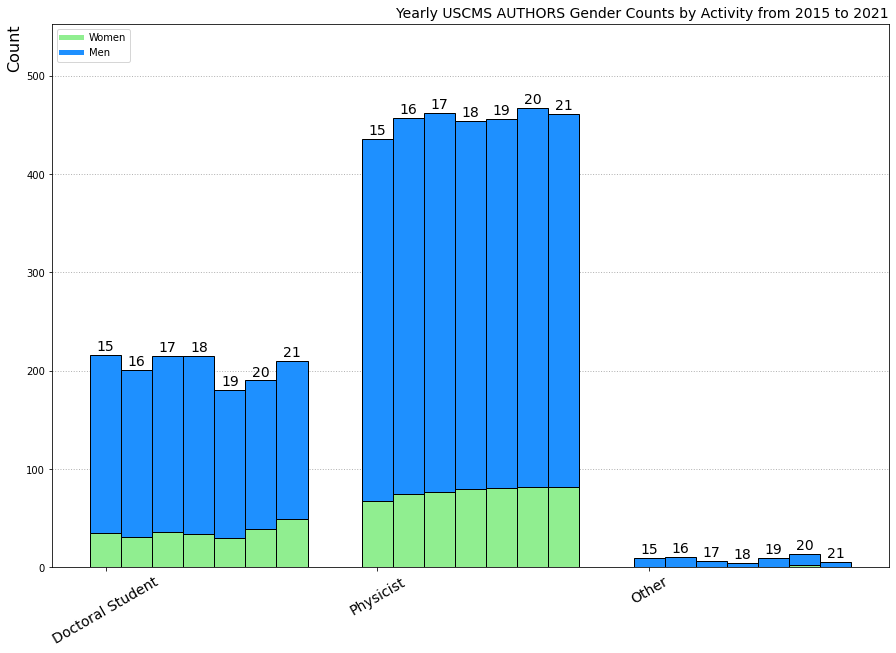

In [44]:
#@markdown ### Plot the Activity Counts by Region per Year 
#@markdown Only groups: `Physicist`, `Doctoral Student`, `Other`

merged_activity = {}
for year in count_activity:
  merged_activity[ year ] = {
      "FEMALE": {}, "MALE": {}, "TOTAL": {}, "FRACTION_F": {}, "FRACTION_M": {}
  }
  for category in merged_activity[ year ]:
    if category in [ "FRACTION_F", "FRACTION_M" ]: continue
    merged_activity[ year ][ category ] = {
        "Doctoral Student": count_activity[ year ][ category ][ "Doctoral Student" ],
        "Physicist": count_activity[ year ][ category ][ "Physicist" ],
        "Other": 0
    }
    for activity in count_activity[ year ][ category ]:
      if activity in [ "Doctoral Student", "Physicist" ]: continue
      else: merged_activity[ year ][ category ][ "Other" ] += count_activity[ year ][ category ][ activity ]

  for activity in merged_activity[ year ][ "TOTAL" ]:
    merged_activity[ year ][ "FRACTION_F" ][ activity ] = merged_activity[ year ]["FEMALE"][ activity ] / merged_activity[ year ][ "TOTAL"][ activity ]
    merged_activity[ year ][ "FRACTION_M" ][ activity ] = merged_activity[ year ]["MALE"][ activity ] / merged_activity[ year ][ "TOTAL"][ activity ]

width = 0.8 / len( yearlist.value )
x = np.arange( 3 )

plt.figure( figsize = (5 * len(x) , 10) )
ax = plt.subplot(111)

for i, year in enumerate( list( yearlist.value ) ):
    ax.bar( x + width * i, list( merged_activity[ year ][ "FEMALE" ].values() )[-len(x):], width,
           color = "lightgreen", edgecolor = "k", zorder=3 )
    ax.bar( x + width * i, list( merged_activity[ year ][ "MALE" ].values() )[-len(x):], width,
           bottom = list( merged_activity[ year ][ "FEMALE" ].values() )[-len(x):],
           color = "dodgerblue", edgecolor = "k", zorder=3 )
    for xi in x:
      ax.text( 
          xi + width * ( i ), 
          max_count * 0.01 + ( ( np.array( list( merged_activity[ year ][ "MALE" ].values() ) ) + np.array( list( merged_activity[ year ][ "FEMALE" ].values() ) ) )[xi] ), 
          year[2:], fontsize = 14, ha = "center"  )
      #break
    
ax.set_title( "Yearly {} {} Gender Counts by Activity from {} to {}".format( 
    regions.value, author.value, yearlist.value[0], yearlist.value[-1]
 ), fontsize = 14, x = 1.0, ha = "right" )
ax.set_ylabel( "Count", y = 1.0, ha = "right", fontsize = 16 )
ax.set_ylim( 
    0, 
    1.2*( np.max( ( np.array( list( merged_activity[ year ][ "MALE" ].values() ) ) + np.array( list( merged_activity[ year ][ "FEMALE" ].values() ) ) ) ) )
)
ax.set_xticks( x )
ax.set_xticklabels( list( merged_activity[ yearlist.value[0] ][ "TOTAL" ].keys() )[-len(x):], fontsize = 14, rotation = 30 )

custom_legend = [
  Line2D( [0], [0], color = "lightgreen", lw = 5 ),
  Line2D( [0], [0], color = "dodgerblue", lw = 5 )
]
ax.legend( custom_legend, [ "Women", "Men" ], loc = 2 )

ax.set_facecolor("white")
ax.grid( b=True, which="major", axis="y", color = [0.7,0.7,0.7], 
        linestyle = ":", linewidth = 1, zorder=0)

if not os.path.exists( os.getcwd() + "/Plots/ ") != True: os.makedirs( os.getcwd() + "/Plots/" )
plt.savefig( "./Plots/Gender by Activity {} {}-{}.png".format( author.value, yearlist.value[0], yearlist.value[-1] ) )
plt.show()